In [3]:
%matplotlib notebook

In [4]:
import numpy as np
from facenet_models import FacenetModel
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.pyplot import text
import skimage.io as io
from PIL import Image
import cv2 as cv
import glob

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

if (torch.cuda.is_available()):
    print("GPU available")

GPU available


In [6]:
from eyemodel import EyeModel

In [10]:
def find_eyes(image_data, *, box_threshold=0.97, prop_const=0.13):
    """
    Displays an image with boxes around people's faces and labels them with names.
    Parameters
    ----------
    image_data : numpy.ndarray, shape-(R, C, 3) (RGB is the last dimension)
        Pixel information for the image.
    """
    i = 0
    leftBox = []
    rightBox = []
    
    while i < 4:
        model = FacenetModel()
        
        # in the future, only analyze the highest probability face?
        boxes, probabilities, landmarks = model.detect(image_data)
        face_detected = True

        if boxes is None or probabilities[0]<box_threshold:
            i+=1
            image_data = cv.rotate(image_data, cv.ROTATE_90_CLOCKWISE)
            continue
        
        box = boxes[0]
        prob = probabilities[0]
        
        lefteye = landmarks[0][0]
        righteye = landmarks[0][1]

        # boxes in form [left,top,right,bottom]

        radius = ((box[3] - box[1]) + (box[2] - box[0]))/2 * prop_const

        leftBox = np.array([lefteye[0] - radius, 
                            lefteye[1] - radius, 
                            lefteye[0] + radius,
                            lefteye[1] + radius])
        rightBox = np.array([righteye[0] - radius, 
                            righteye[1] - radius, 
                            righteye[0] + radius,
                            righteye[1] + radius])

        leftBox = np.round(np.array(leftBox)).astype(int)
        rightBox = np.round(np.array(rightBox)).astype(int)
        
        break

    if len(leftBox)>0:
        fig, ax = plt.subplots()
        ax.imshow(image_data)

        ax.add_patch(Rectangle(leftBox[:2], *(leftBox[2:] - leftBox[:2]), fill=None, lw=2, color="yellow"))
        ax.add_patch(Rectangle(rightBox[:2], *(rightBox[2:] - rightBox[:2]), fill=None, lw=2, color="yellow"))
        
        ax.plot(lefteye[0], lefteye[1], "+", color="green")
        ax.plot(righteye[0], righteye[1], "+", color="green")
    
    return leftBox, rightBox, image_data

Filepath: hyojae.png


<IPython.core.display.Javascript object>


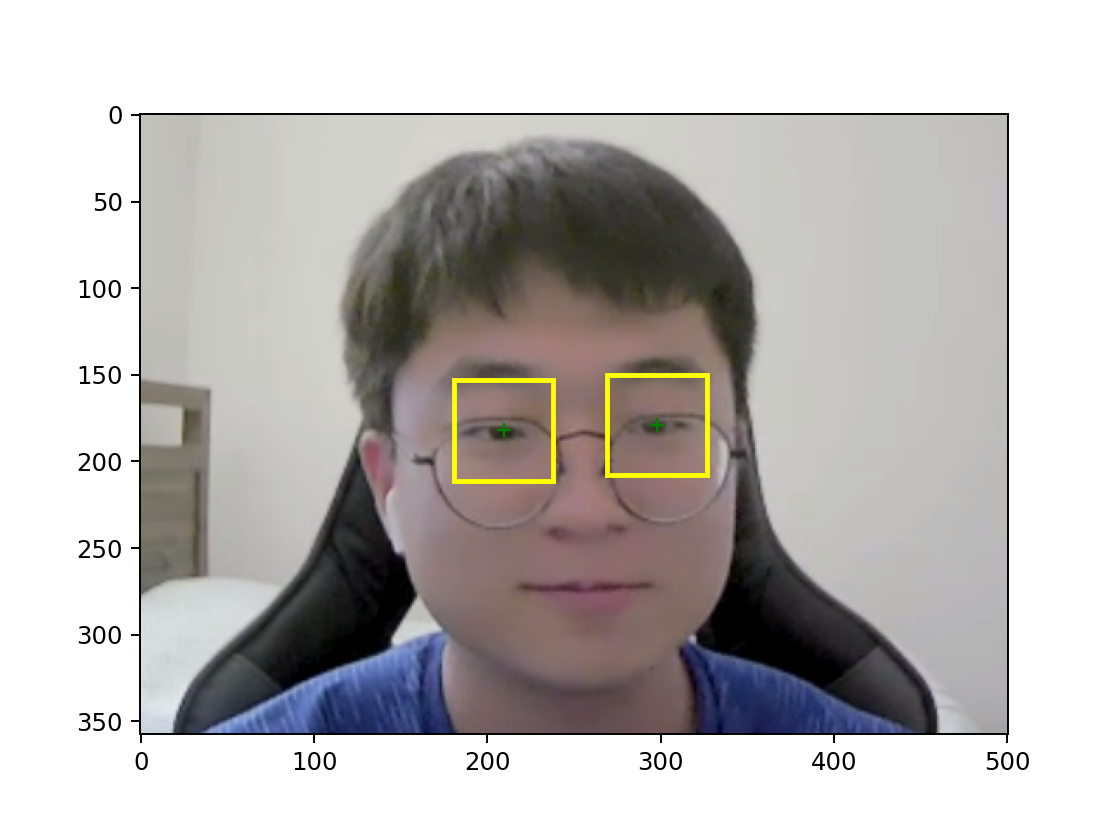

(array([181, 153, 238, 211]),
 array([269, 150, 327, 208]),
 array([[[194, 193, 190],
         [194, 194, 189],
         [194, 194, 189],
         ...,
         [189, 189, 186],
         [189, 189, 186],
         [189, 189, 186]],
 
        [[194, 193, 190],
         [194, 194, 189],
         [194, 194, 189],
         ...,
         [189, 189, 186],
         [189, 189, 186],
         [189, 189, 186]],
 
        [[194, 193, 190],
         [194, 194, 189],
         [194, 194, 189],
         ...,
         [189, 189, 186],
         [189, 189, 186],
         [189, 189, 186]],
 
        ...,
 
        [[203, 211, 223],
         [202, 210, 221],
         [201, 210, 220],
         ...,
         [165, 164, 165],
         [165, 164, 165],
         [165, 164, 165]],
 
        [[201, 209, 221],
         [202, 210, 222],
         [203, 212, 222],
         ...,
         [165, 163, 165],
         [165, 164, 165],
         [165, 164, 165]],
 
        [[199, 207, 221],
         [201, 210, 222],
        

In [14]:
filepath = input("Filepath: ")
pic = io.imread(str(filepath))
if pic.shape[-1] == 4:
        pic = pic[..., :-1]
find_eyes(pic)

In [6]:
def eye_img(pic):
    if pic.shape[-1] == 4:
        # Image is RGBA, where A is alpha -> transparency
        # Must make image RGB.
        pic = pic[..., :-1]  # png -> RGB

    left, right, pic = find_eyes(pic)

    if len(left)==0:
        print("FACE NOT FOUND")
        return None

    
    gray = cv2.cvtColor(pic, cv2.COLOR_RGB2GRAY)
    
    # boxes in form [left,top,right,bottom]
    fig, axes = plt.subplots(1,2)

    lefteye = gray[left[1]:left[3], left[0]:left[2]]
    righteye = gray[right[1]:right[3], right[0]:right[2]]
    
    lefteye = cv2.resize(lefteye, (24,24), interpolation = cv2.INTER_LINEAR)
    righteye = cv2.resize(righteye, (24,24), interpolation = cv2.INTER_LINEAR)

    axes[0].imshow(lefteye, cmap="gray")
    axes[1].imshow(righteye, cmap="gray")
    
    return lefteye, righteye

In [7]:
from camera import take_picture
import numpy as np
import skimage.io as io

def user_interface():
    while True:
        choice = input("Upload (u) or take a photo (c)? ")
        if choice=="u":
            filepath = input("Filepath: ")
            pic = io.imread(str(filepath))
            break
        elif choice=="c":
            pic = take_picture()
            break
        else:
            print("Invalid input. Try again. ")
        eye_img(pic)

In [8]:
'''filepath = input("Filepath: ")
# pic = np.array(Image.open(filepath))[:,:,:3]
# shape-(Height, Width, Color)
pic = io.imread(str(filepath))
if pic.shape[-1] == 4:
    # Image is RGBA, where A is alpha -> transparency
    # Must make image RGB.
    pic = pic[..., :-1]  # png -> RGB
i = 0
face_detected = False
while (not face_detected and i < 4):
    leftBox, rightBox, face_detected = find_eyes(pic)
    pic = cv.rotate(pic, cv.ROTATE_90_CLOCKWISE)
    i += 1
'''
print()

In [9]:
cuda = torch.device('cuda')
print(type(cuda))

<class 'torch.device'>


In [10]:
# class EyeModel(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # assumes 32x32
#         self.conv1 = nn.Conv2d(1, 5, 3)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(5, 7, 3)
#         self.fc1 = nn.Linear(112, 2)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         #         x = F.softmax(self.fc1(x), dim=1)
#         x = self.fc1(x)
#         return x


# # next(model.parameters()).is_cuda

In [11]:
class CustomImageDataset(Dataset):
    def __init__(self, numpydata, numpylabels, transform=None, target_transform=None):
        self.imgs = numpydata
        self.img_labels = numpylabels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        label = self.img_labels[idx]
        image = self.imgs[idx]
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [12]:
'''
#OLD CODE
closed_x = np.empty((1,24,24), dtype=int)
open_x = np.empty((1,24,24), dtype=int)

for filename in glob.glob('train_dataset/closedLeftEyes/*.*'):
    img = cv.imread(filename, 0)
    closed_x = np.concatenate((closed_x, np.array([img])))
    # 	closed_x.append(img)
    
for filename in glob.glob('train_dataset/closedRightEyes/*.*'):
    img = cv.imread(filename, 0)
    closed_x = np.concatenate((closed_x, np.array([img])))
    # 	closed_x.append(img)

for filename in glob.glob('train_dataset/openLeftEyes/*.*'):
    img = cv.imread(filename, 0)
    open_x = np.concatenate((open_x, np.array([img])))
    # 	open_x.append(img)

for filename in glob.glob('train_dataset/openRightEyes/*.*'):
    img = cv.imread(filename, 0)
    open_x = np.concatenate((open_x, np.array([img])))
    # 	open_x.append(img)
# closed_x = np.array(closed_x)
# open_x = np.array(open_x)
closed_x = closed_x[1:]
open_x = open_x[1:]'''
print("")

In [13]:
closed_x = np.empty((1,24,24))
open_x = np.empty((1,24,24))

for filename in glob.glob('train_dataset/closed*/*.*'):
    img = np.array([cv.imread(filename, 0)])/255 + 1

    closed_x = np.concatenate((closed_x, img))

for filename in glob.glob('train_dataset/open*/*.*'):
    img = np.array([cv.imread(filename, 0)])/255 + 1

    open_x = np.concatenate((open_x, img))

closed_x = closed_x[1:]
open_x = open_x[1:]

In [14]:
'''print(type(img[0,0]))
print(open_x)'''
print("")

In [15]:
train_x = np.vstack((closed_x[:int(len(closed_x)*0.8)], open_x[:int(len(open_x)*0.8)]))
valid_x = np.vstack((closed_x[int(len(closed_x)*0.8):], open_x[int(len(open_x)*0.8):]))

train_y = [0 for i in range(int(len(closed_x)*0.8))] + [1 for i in range(int(len(open_x)*0.8))]
valid_y = [0 for i in range(len(closed_x) - int(len(closed_x)*0.8))] + [1 for i in range(len(open_x) - int(len(open_x)*0.8))]
# print(train_y[-10])
# print(train_y)
train_x = torch.tensor(train_x, dtype=torch.float32, device=cuda)
valid_x = torch.tensor(valid_x, dtype=torch.float32, device=cuda)

train_y = torch.tensor(train_y, dtype=torch.float32, device=cuda)
valid_y = torch.tensor(valid_y, dtype=torch.float32, device=cuda)

In [16]:
'''print(train_y[-10])'''
# print(train_x)

'print(train_y[-10])'

In [17]:
def accuracy(outputs, labels):
    o = torch.argmax(outputs, dim=1)
#     print(o.shape)
#     print(labels.shape)
    return (sum(o == labels) / len(labels))

In [18]:
model = EyeModel().to(cuda)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100
batch_size = 32

data = CustomImageDataset(train_x, train_y)
trainloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.reshape(len(inputs),1,24,24)#.float()
        labels = labels.long()

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 70 == 69:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 70:.3f}')
            running_loss = 0.0
            print(f'[{epoch + 1}, {i + 1:5d}] accuracy: {accuracy(outputs, labels)}')
    
    

print('Finished Training')

[1,    70] loss: 0.682
[1,    70] accuracy: 0.5
[2,    70] loss: 0.559
[2,    70] accuracy: 0.71875
[3,    70] loss: 0.437
[3,    70] accuracy: 0.78125
[4,    70] loss: 0.384
[4,    70] accuracy: 0.78125
[5,    70] loss: 0.327
[5,    70] accuracy: 0.90625
[6,    70] loss: 0.312
[6,    70] accuracy: 1.0
[7,    70] loss: 0.259
[7,    70] accuracy: 0.9375
[8,    70] loss: 0.245
[8,    70] accuracy: 0.84375
[9,    70] loss: 0.225
[9,    70] accuracy: 0.90625
[10,    70] loss: 0.219
[10,    70] accuracy: 0.84375
[11,    70] loss: 0.205
[11,    70] accuracy: 0.96875
[12,    70] loss: 0.186
[12,    70] accuracy: 0.875
[13,    70] loss: 0.178
[13,    70] accuracy: 0.9375
[14,    70] loss: 0.180
[14,    70] accuracy: 0.96875
[15,    70] loss: 0.171
[15,    70] accuracy: 0.875
[16,    70] loss: 0.178
[16,    70] accuracy: 0.90625
[17,    70] loss: 0.152
[17,    70] accuracy: 0.96875
[18,    70] loss: 0.148
[18,    70] accuracy: 0.9375
[19,    70] loss: 0.144
[19,    70] accuracy: 0.875
[20,    7

In [19]:
torch.save(model, "model.pb")

In [20]:
model = torch.load("model.pb")

criterion = nn.CrossEntropyLoss()

batch_size = len(valid_x)

valid_data = CustomImageDataset(valid_x, valid_y)
valid_trainloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

with torch.no_grad():
    running_loss = 0.0
    for i, v_data in enumerate(valid_trainloader, 0):
        v_inputs, v_labels = v_data
        v_inputs = v_inputs.reshape(len(v_inputs),1,24,24)#.float()
        v_labels = v_labels.long()
        
        # forward
        v_outputs = model(v_inputs)
        loss = criterion(v_outputs, v_labels)

        # print statistics
#         running_loss += loss.item()
#         print(f'loss: {running_loss / 2000:.3f}')
        print(f'loss: {loss}')
        print(f'accuracy: {accuracy(v_outputs, v_labels)}')

loss: 0.14131179451942444
accuracy: 0.9536082744598389


In [152]:
'''epochs = 10
batch_size = 32

for iteration in range(0, epochs):
    indices = np.arange(len(train_x))
    np.random.shuffle(indices)
    
    # trains the model by improving the loss and accuracy metrics for the training data in batches
    for batch_count in range(0, len(train_x)//batch_size):
        batch_indices = indices[batch_count * batch_size : (batch_count+1) * batch_size]
        inputs = train_x[batch_indices]
        labels = train_y[batch_indices]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if (batch_count) % 10 == 9:
            print(f'TRAINING loss is {loss}')
        

    # creates a shuffled array of testing indices  
    test_indices = np.arange(len(valid_x))
    np.random.shuffle(test_indices)
    
    for batch_count in range(0, len(valid_x)//batch_size):
        test_batch_indices = test_indices[batch_count * batch_size : (batch_count+1) * batch_size]
        inputs = test_x[test_batch_indices]
        labels = test_y[test_batch_indices]

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
    
        if (batch_count) % 10 == 9:
            print(f'TESTING loss is {loss}')
'''
print()